# TReNDS Neuroimaging - Data exploration

## Contents


- <a href='#1'>1. A gentle introduction to MRI</a>  
     - <a href='#1-1'>1.1 What is a MRI?</a>
     - <a href='#1-2'>1.2 One should not confuse MRI, CT scan and X-ray</a>
     - <a href='#1-3'>1.3 How does a MRI actually work?</a>
     - <a href='#1-4'>1.4 How do we translate magnetic fields into an image?</a>
- <a href='#2'>2. Data exploration</a>
     - <a href='#2-1'>2.1 Target distributions</a>
     - <a href='#2-2'>2.2 SBM loadings</a>
     - <a href='#2-3'>2.3 FNC correlation</a>
     - <a href='#2-4'>2.4 Visualizing 3D spatial maps</a>
- <a href='#3'>3. Basic modelling</a>
     - <a href='#3-1'>3.1 Preparing data</a>
     - <a href='#3-2'>3.2 Training</a>
- <a href='#4'>4. Advanced modelling</a>
     - <a href='#4-1'>4.1 Preparing data</a>
     - <a href='#4-2'>4.2 Modelling</a>
     - <a href='#4-3'>4.3 Training</a>
- <a href='#5'>5. Submission</a>

**This kenrel will be a work in progress, and I will keep on updating it as the competition progresses and I gain more insight about the data.**

If you find this kernel useful, please consider upvoting it, it motivates me to write more quality content.

**Sources**: 
- https://www.healthline.com/health/head-mri
- https://kids.frontiersin.org/article/10.3389/frym.2019.00023
- https://www.kaggle.com/soham1024/visualization-using-nilearn
- https://www.kaggle.com/zacktack/data-scientist-journey-neuroimaging-lgbm

**For a deeper understanding**:
- https://www.youtube.com/watch?v=Gpa0Pgsx7SI
- https://www.youtube.com/watch?v=Ok9ILIYzmaY


**Previous competitons**: 
- https://www.kaggle.com/c/mlsp-2014-mri/overview

## <a id='#1'>A gentle introduction to MRI</a>

### <a id='#1-1'>What is a MRI?</a>

The Magnetisc Resonance Imaging (MRI) is non-invasive test that produces detailed images of your brain and brain stem. An MRI machnie creates the images using a magnetic field and radio waves. 

### <a id="#1-2">One should not confound MRI, CT scan and X-ray...</a>

A MRI scan is different from a CT scan or an X-ray in that **it doesn’t use radiation to produce images**. An MRI scan combines images to create **a 3-D picture of your internal structures**, so it’s more effective than other scans at detecting abnormalities in small structures of the brain such as the pituitary gland and brain stem. 

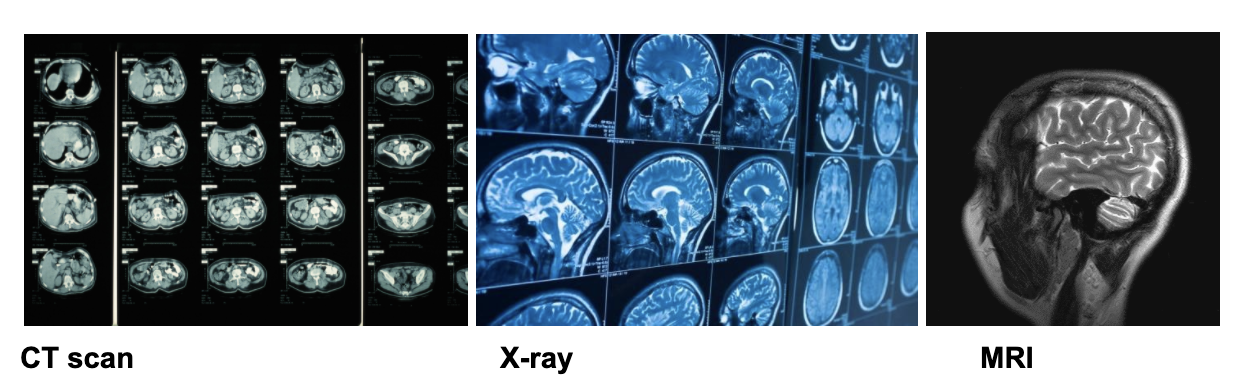

### <a href='#1-3'>How does a MRI actually work?</a>

MRI allows us to see inside the human body with amazing detail, by using magnets and radio waves. The MRI scanner is essentially a giant magnet. MRI uses magnetic fields and radio waves to measure how much water is in different tissues of the body, maps the location of the water and then uses this information to generate a detailed image. The images are so detailed because our bodies are made up of around 65% water, so we have lots of signal to measure.



Water molecule is H2O, meaning it is made up of two hydrogen atoms and one oxygen atom. Looking closer at hydrogen, we see it has central nucleus containing a single proton. Like the Earth spinning on its axis with a north and south magnetic pole, each spinning hydrogen proton is like a tiny magnet that spins around on its own axis. This spinning motion is known as precession. At any moment in time, all the billions of hydrogen protons in our bodies are all in random positions and spinning on their axes. 

However, this randomness changes when we place a human body into a very strong magnetic field, like an MRI scanner. We call the scanners magnetic field the B0 field. The hydrogen protons do not physically move in your body when you enter an MRI scanner, their axes just align along the direction of the B0 field. Some will align “up” (parallel) and some will align “down” (anti-parallel), while still spinning around on their own axes. Due to the law of quantum physics, there are always just slightly more “up” protons than “down.” If you now think about the total magnet field generated from all our hydrogen protons, these tiny magnets almost cancel each other out, to leave only the magnetic field from the small proportion of extra “up” protons, and it is this small magnetic field that we can measure using MRI.

We use something called a radio frequency (RF) pulse, to disturb or flip all the protons, at the same time, out of alignment from the scanner's magnetic field. The frequency of the RF pulse must be the same as the frequency of the spinning hydrogen protons, so they can exchange energy, so that they are in resonance with each other. Resonance enables the protons to absorb enough energy from the RF pulse to rotate their axes away from the B0 field, so that the MRI scanner can measure it. 


#### If the whole body is full of hydrogen “up” protons all spinning at the same precessing frequency in the B0, how do we target just the ones in the brain to investigate mental health? 

We use the fact that the precessional frequency of the protons is dependant on the magnetic field strength. We apply a second magnetic field, B1 that varies across the body. In the example shown in hydrogen protons in the head will then be spinning faster than those in the chest, stomach and feet. Then, we tune the RF pulse to the precessing frequency of the hydrogen protons in the head. The RF pulse will then only be resonant with the protons in the brain. Therefore, only the protons in the brain will absorb energy from the RF pulse and be flipped away from the B0 field. We can obviously tune our RF pulse to be resonant with protons in other parts of the body, like the feet, if we were interested in imaging the feet!

### <a href='#1-4'>How do we translate magnetic fields into an image?</a>

When the RF pulse is turned off, the protons flip back and realign along the main magnetic field, B0. As the protons flip back and realign with B0, they give off energy. Different tissues in the body give off different amounts of energy. To measure this emitted energy, we require some special equipment (called a coil) that is placed around the body part we are imaging. The coil acts as an antenna and detects the released energy as an electrical current. The electrical current is transformed via a Fourier transform. Because protons in the different kinds of tissues in the brain, such as gray matter, white matter and blood, all give off different amounts of energy, the result of the transformed energy is a highly detailed image of the tissue inside the brain.

## <a href='#2'>Data exploration</a>

As you know, the data is multimodal, meaning that multiple features can be fed to a machine learning model. In addition to the MRI images, we are given several additional features to increase our model performance.

In [ ]:
!pip install -q joypy

In [ ]:
# Importing dependencies

from sklearn.model_selection import KFold, train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import joypy

from tqdm.notebook import tqdm
from glob import glob
import gc

import nilearn as nl
import nilearn.plotting as nlplt
import nibabel as nib

import h5py

import lightgbm as lgb

from scipy.stats import skew, kurtosis

import os, random

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

from tensorflow.keras.utils import Sequence

In [ ]:
# Loading train scores

MAIN_DATA_PATH = '/kaggle/input/trends-assessment-prediction/'

train_scores_df = pd.read_csv(MAIN_DATA_PATH + 'train_scores.csv')
icn_numbers_df = pd.read_csv(MAIN_DATA_PATH + 'ICN_numbers.csv')
loading_df = pd.read_csv(MAIN_DATA_PATH + 'loading.csv')
fnc_df = pd.read_csv(MAIN_DATA_PATH + 'fnc.csv')

### <a href='#2-1'>Target distributions</a>

The train_scores.csv file contains the targets that we need to predict.

In [ ]:
train_scores_df.head()

In [ ]:
# Plot the distribution of the target variables

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

sns.distplot(train_scores_df['age'], ax=ax[0])
ax[0].set_title('Age')

sns.distplot(train_scores_df['domain1_var1'], ax=ax[1])
ax[1].set_title('Domain 1 - Var 1')

sns.distplot(train_scores_df['domain1_var2'], ax=ax[2])
ax[2].set_title('Domain 1 - Var 2')

sns.distplot(train_scores_df['domain2_var1'], ax=ax[3])
ax[3].set_title('Domain 2 - Var 1')

sns.distplot(train_scores_df['domain2_var2'], ax=ax[4])
ax[4].set_title('Domain 2 - Var 2')

fig.suptitle('Target distributions', fontsize=14)

The distributions are bell-shaped. Age and domain 2 variables seems to have a slight skew. Furthermore, the kurtosis is small, meaning that there is not much weight in the tails.

In [ ]:
# Compute statistics

print("Kurtosis (Fisher's definition)")
train_scores_df.kurtosis()

Indeed, the target variables are normally-distributed. Note that Fisher's definition means that the kurtosis of a Gaussian distribution is 0.

In [ ]:
round(train_scores_df.isna().sum() / len(train_scores_df) * 100, 2)

Around 7.5% of domain1_var1 and domain1_var2 are missing. An appropriate pre-processing needs to be tested. We can either drop them (not the best strategy, since we have only 5000-odd samples) or use the mean or the column (the option we choose here).

In [ ]:
train_scores_df.fillna(train_scores_df.mean(), inplace=True)

Always double-check your work...

In [ ]:
train_scores_df.isna().sum()

### <a href='#2-2'>SBM loadings</a>

Per the competition documentation,

> The first set of features are source-based morphometry (SBM) loadings. These are subject-level weights from a group-level ICA (independent component analysis) decomposition of gray matter concentration maps from structural MRI (sMRI) scans.

In [ ]:
loading_df.head()

In [ ]:
targets = loading_df.columns[1:]

plt.figure(figsize=(16,10), dpi= 80)
fig, axes = joypy.joyplot(loading_df, column=list(targets), ylim='own', figsize=(14,10))

# Decoration
plt.title('Source-based morphometry loadings distribution', fontsize=22)
plt.show()

Let's know build our training set composed of multiple sets of features.

In [ ]:
features_df = pd.merge(train_scores_df, loading_df, on=['Id'], how='left')
features_df.head()

Since we still have relatively few features, let's investigate the correlation between target variables and features.

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
cols = features_df.columns[1:]
sns.heatmap(features_df[cols].corr(), annot=True, cmap='RdYlGn', ax=ax)

### <a href='#2-3'>FNC correlation</a>

This dataframe contains static FNC correlation features for both train and test samples.

As given in the competition data summary,

> The second set are static functional network connectivity (FNC) matrices. These are the subject-level cross-correlation values among 53 component timecourses estimated from group inform guided ICA of resting state functional MRI.

#### What are functional network connectivity matrices?

Functional connectivity is the **connectivity between brain regions that share functional properties**. More specifically, it can be defined as the temporal correlation between spatially remote neurophysiological events, expressed as deviation from statistical independence across these events in distributed neuronal groups and areas. This applies to both resting state and task-state studies. While functional connectivity can refer to correlations across subjects, runs, blocks, trials, or individual time points, resting state functional connectivity focuses on connectivity assessed across individual BOLD time points during resting conditions. Functional connectivity has also been evaluated using the perfusion time series sampled with arterial spin labeled perfusion fMRI.

Source: https://en.wikipedia.org/wiki/Resting_state_fMRI#Functional

In [ ]:
fnc_df.head()

In [ ]:
# No NaN values in the DataFrame

fnc_df.isna().sum().sum()

In [ ]:
features_df = pd.merge(features_df, fnc_df, how='left', on='Id')
features_df.head()

### <a href='#2-4'>Visualizing 3D spatial maps</a>

Credits to: https://www.kaggle.com/soham1024/visualization-using-nilearn

In [ ]:
!wget https://github.com/Chaogan-Yan/DPABI/raw/master/Templates/ch2better.nii

In [ ]:
mask_filename = '../input/trends-assessment-prediction/fMRI_mask.nii'
smri_filename = 'ch2better.nii'

mask_niimg = nl.image.load_img(mask_filename)

def load_subject(filename, mask_niimg):
    subject_data = None
    
    with h5py.File(filename, 'r') as f:
        subject_data = f['SM_feature'][()]
        
    subject_data = np.moveaxis(subject_data, [0, 1, 2, 3], [3, 2, 1, 0])
    subject_niimg = nl.image.new_img_like(mask_niimg, subject_data, affine=mask_niimg.affine, copy_header=True)
    
    return subject_niimg 

In [ ]:
fMRI_train_data_path = '../input/trends-assessment-prediction/fMRI_train/'
filenames = random.choices(os.listdir(fMRI_train_data_path), k=4)

Using soham1024's function, we change the dimensions of the 4d array that is in the Matlab file. We flip the axes such that the first two axes are the width and height.

In [ ]:
for filename in filenames:
    subject_filename = os.path.join(fMRI_train_data_path, filename)
    subject_niimg = load_subject(subject_filename, mask_niimg)

    print("Image shape is %s" % (str(subject_niimg.shape)))
    num_components = subject_niimg.shape[-1]
    print("Detected {num_components} spatial maps".format(num_components=num_components))

    nlplt.plot_prob_atlas(subject_niimg, 
                          bg_img=smri_filename,
                          view_type='filled_contours',
                          draw_cross=False,
                          title='All %d spatial maps' % num_components,
                          threshold='auto')

#### Visualize independent components (IC)

In [ ]:
filename = random.choice(os.listdir(fMRI_train_data_path))
subject_filename = os.path.join(fMRI_train_data_path, filename)
subject_niimg = load_subject(subject_filename, mask_niimg)

grid_size = int(np.ceil(np.sqrt(53)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*10, grid_size*10))
[axi.set_axis_off() for axi in axes.ravel()]
row = -1 

for i, cur_img in enumerate(nl.image.iter_img(subject_niimg)):
    col = i % grid_size
    if col == 0:
        row += 1
    
    nlplt.plot_stat_map(cur_img,
                        bg_img=smri_filename,
                        title='IC %d' % i,
                        axes=axes[row, col],
                        threshold=3,
                        colorbar=False)

## <a href='#3'>Basic modelling</a>

For a basic modelling using SVM, I hhave used RAPIDS SVM as shown in Ahmet Erdem's kernel: https://www.kaggle.com/aerdem4/rapids-svm-on-trends-neuroimaging and used feature engineering from https://www.kaggle.com/jafarib/trends-eda-fe-submission

### <a href='#3-1'> Preparing data</a>

For this model, we will only be using basic features, and not the actual MRI image. As you'll see, the model works decently.

In [ ]:
# Loading 
fnc_df = pd.read_csv("../input/trends-assessment-prediction/fnc.csv")
loading_df = pd.read_csv("../input/trends-assessment-prediction/loading.csv")
labels_df = pd.read_csv("../input/trends-assessment-prediction/train_scores.csv")

fnc_features, loading_features = list(fnc_df.columns[1:]), list(loading_df.columns[1:])
df = fnc_df.merge(loading_df, on="Id")
labels_df["is_train"] = True

df = df.merge(labels_df, on="Id", how="left")

target_cols = ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']

test_df = df[df["is_train"] != True].copy()
train_df = df[df["is_train"] == True].copy()

In [ ]:
y_train_df = train_df[target_cols]
train_df = train_df.drop(target_cols + ['is_train'], axis=1)
test_df = test_df.drop(target_cols + ['is_train'], axis=1)

FNC_SCALE = 1/500
test_df[fnc_features] *= FNC_SCALE
train_df[fnc_features] *= FNC_SCALE

In [ ]:
train_df.head()

In [ ]:
test_df.head()

**We know that there is no data leakage between patients since each patient has a unique id.**

### <a href='#3-2'> Training</a>

In [ ]:
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [ ]:
param = {'objective':'regression',
        'metric':'rmse',
        'bossting_type':'gbdt',
        'learning_rate':0.01,
        'max_depth':-1}

output = pd.DataFrame()

for target in ['age','domain1_var1','domain1_var2','domain2_var1','domain2_var2']:
    
    X_train, X_val, y_train, y_val = train_test_split(train_df.iloc[:,1:], y_train_df[target], test_size=0.2, shuffle=True, random_state=20)
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    model = lgb.train(param, 
                      train_data, 
                      10000, 
                      early_stopping_rounds=15, 
                      valid_sets=[val_data], 
                      verbose_eval=50)
    
    temp = pd.DataFrame(test_df['Id'].apply(lambda x:str(x)+ '_'+ target))
    temp['Predicted'] = model.predict(test_df.iloc[:,1:])
    output = pd.concat([output,temp])

In [ ]:
sample_submission = pd.read_csv("/kaggle/input/trends-assessment-prediction/sample_submission.csv")
output = sample_submission.drop('Predicted',axis=1).merge(output,on='Id',how='left')

## <a href="5-1">Submission - Ensemble</a>

In [ ]:
sub_df = pd.read_csv("../input/trends-svc-rapids-ai/submission.csv")

In [ ]:
final_sub = pd.DataFrame(data={
    'id':sample_submission['Id'],
    'Predicted': 0.7*output['Predicted'] + 0.3*sub_df['Predicted']
})

In [ ]:
sub_df.to_csv("submission.csv", index=False)